In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score)

## Data Cleaning & Data Engineering

### Target Variable Design: Fast-Growth Firms
In this study, we define the prediction target as **fast-growth firms**, aiming to identify companies that experienced significant expansion in sales over a two-year period. Specifically, we use the log difference in sales between 2013 and 2015 as our main metric of growth:

$$
\text{sales\_growth\_2y} = \log(\text{sales}_{2015}) - \log(\text{sales}_{2013})
$$

To operationalize this target, we rank all firms in the dataset by their two-year log sales growth and define the top 20% as fast-growing. This threshold corresponds to the 80th percentile of the distribution.
The rationale behind this definition is threefold:
1. **Medium-term stability**: Using a two-year growth window, rather than a single year, smooths out short-term fluctuations and provides a more reliable indicator of sustained business expansion.
2. **Log transformation**: Applying a logarithmic transformation to sales before calculating growth helps mitigate the impact of outliers and makes growth more comparable across firms of different sizes.
3. **Percentage-like interpretation**: The log difference closely approximates a percentage growth rate, making it a more intuitive and economically meaningful measure of performance improvement.
This approach ensures that the fast-growth classification is both statistically robust and conceptually grounded in corporate finance principles.

In [4]:
df = pd.read_csv("cs_bisnode_panel.csv")
df = df[(df["year"] >= 2010) & (df["year"] <= 2015)].copy()

In [5]:
# Sales Data
df["sales_mil"] = df["sales"] / 1_000_000
df["sales_mil_log"] = np.log(df["sales_mil"].replace(0, np.nan))
df["sales_mil_log_sq"] = df["sales_mil_log"] ** 2

# New Company
df["age"] = (df["year"] - df["founded_year"]).clip(lower=0)
df["new"] = ((df["age"] <= 1) | (df["balsheet_notfullyear"] == 1)).astype(int)

# Increase Rate
df = df.sort_values(["comp_id", "year"])
df["d1_sales_mil_log"] = df.groupby("comp_id")["sales_mil_log"].diff().fillna(0)
df["d1_sales_mil_log_mod"] = np.where(df["new"] == 1, 0, df["d1_sales_mil_log"])

# Sales Growth
sales_pivot = df.pivot(index="comp_id", columns="year", values="sales_mil_log")
sales_pivot["sales_growth_5y"] = sales_pivot[2015] - sales_pivot[2010]
growth = sales_pivot[["sales_growth_5y"]].dropna().reset_index()

df = df.merge(growth, on="comp_id", how="left")
drop_vars = ["address", "zip", "county_code", "founded_year", "sales", "balsheet_length",
             "balsheet_notfullyear", "comp_name", "id", "status_alive", "exit_year",
             "exit", "death_year", "death_code", "begin", "end", "COGS"]
df.drop(columns=[col for col in drop_vars if col in df.columns], inplace=True)

/Library/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


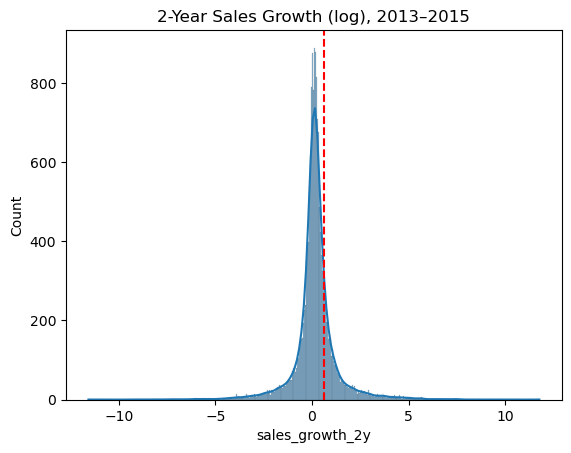

fast_growth
0    0.867338
1    0.132662
Name: proportion, dtype: float64


In [6]:
df = df.sort_values(["comp_id", "year"])
df["sales_growth_2y"] = df.groupby("comp_id")["sales_mil_log"].diff(periods=2)
df_model = df[df["year"] == 2015].copy()

# fast_growth defined as top 20% growth companies
threshold = df_model["sales_growth_2y"].quantile(0.8)
df_model["fast_growth"] = (df_model["sales_growth_2y"] >= threshold).astype(int)

sns.histplot(df_model["sales_growth_2y"], kde=True)
plt.axvline(threshold, color="red", linestyle="--")
plt.title("2-Year Sales Growth (log), 2013–2015")
plt.show()
print(df_model["fast_growth"].value_counts(normalize=True))

### Distribution of Sales Growth (log), 2013–2015

Figure X illustrates the distribution of the two-year log sales growth (`sales_growth_2y`), calculated as the difference between the logarithm of sales in 2015 and 2013. The histogram reveals a highly concentrated distribution centered around zero, with a sharp peak and fat tails. This reflects that the majority of firms experienced relatively stable or modest changes in sales, while a smaller subset either grew or declined significantly.

To identify **fast-growth firms**, we defined a binary label based on the 80th percentile of this distribution, indicated by the red dashed line in the plot. Firms with log sales growth above this threshold are classified as fast-growing (`fast_growth = 1`), while the rest are assigned a value of 0. This choice ensures that the label reflects firms with exceptionally high growth performance relative to the sample.

The resulting class distribution is imbalanced, with approximately **13.3%** of firms labeled as fast-growing. This skew is typical in real-world firm-level datasets. The figure thus serves both as a validation of our label construction method and as a reference for understanding the nature of the prediction target.

In [8]:
# Fast Growth
df_label = df[df["year"] == 2015].copy()
threshold = df_label["sales_growth_2y"].quantile(0.8)
df_label["fast_growth"] = (df_label["sales_growth_2y"] >= threshold).astype(int)
X = df[df["year"] == 2014].copy()
model_df = X.merge(df_label[["comp_id", "fast_growth"]], on="comp_id", how="inner")

df.to_csv("bisnode_panel_2010_2015_full_cleaned.csv", index=False)
model_df.to_csv("bisnode_model_2014_predict_2015_cleaned.csv", index=False)

In [9]:
df = pd.read_csv("bisnode_model_2014_predict_2015_cleaned.csv")
sns.set(style="whitegrid")

In [10]:
print(df["fast_growth"].unique())

[0 1]


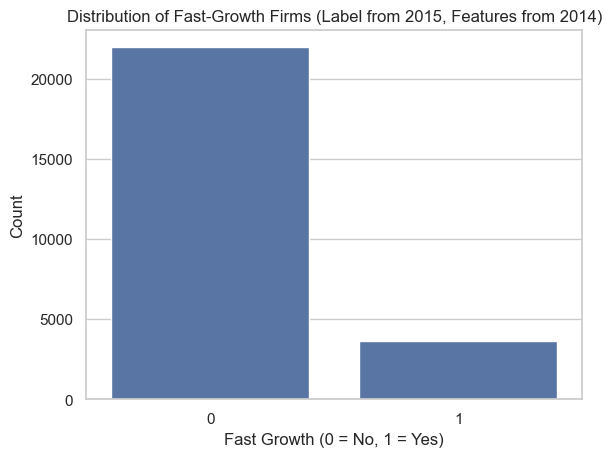

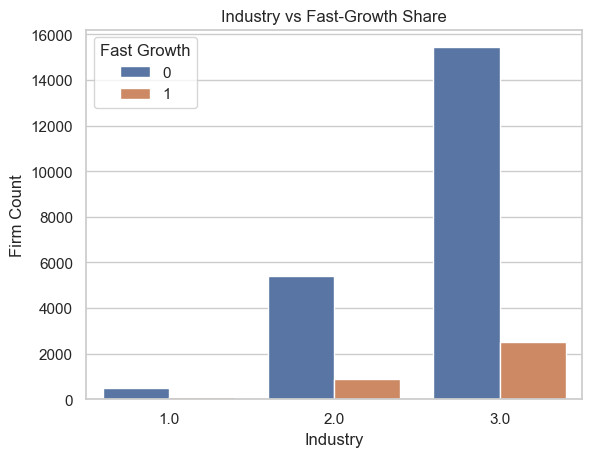

In [11]:
# Plot Fast-Growth distribution
sns.countplot(x="fast_growth", data=model_df)
plt.title("Distribution of Fast-Growth Firms (Label from 2015, Features from 2014)")
plt.xlabel("Fast Growth (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Industry split
sns.countplot(x="ind", hue="fast_growth", data=model_df)
plt.title("Industry vs Fast-Growth Share")
plt.xlabel("Industry")
plt.ylabel("Firm Count")
plt.legend(title="Fast Growth")
plt.show()

### Class Distribution and Timing Strategy for Fast-Growth Prediction

The bar chart above shows the class distribution of the target variable `fast_growth`, which is constructed based on log sales growth between 2013 and 2015. Firms with two-year log sales growth above the 80th percentile are labeled as fast-growing (1), while the rest are labeled as non-fast-growing (0). This results in a class imbalance, with approximately 13% of firms classified as fast-growing.

#### Rationale for Label Timing (2015) and Feature Year (2014)

To ensure a realistic and forward-looking prediction setup, we use **2015 outcomes** to define the label, but rely on **2014 financial and firm-level characteristics** as predictive features. 
There are several important motivations behind this design:

1. **Avoiding Look-Ahead Bias**: By strictly using past features (2014) to predict future outcomes (growth observed up to 2015), we ensure the model is not trained on any information that would not be available at the time of prediction.

2. **Capturing Lagged Effects**: Firm growth is typically driven by past characteristics, such as investment levels, profitability, liquidity, and organizational structure. These drivers often take time to translate into realized sales growth, making one-year-lagged predictors more economically meaningful.

3. **Policy and Business Relevance**: Decision-makers rarely have access to current-period outcome data. A model trained to predict future performance based on observable past data provides actionable insights for resource allocation, credit scoring, or early identification of high-potential firms.

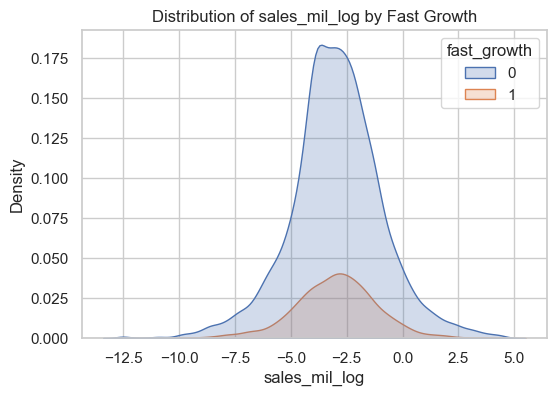

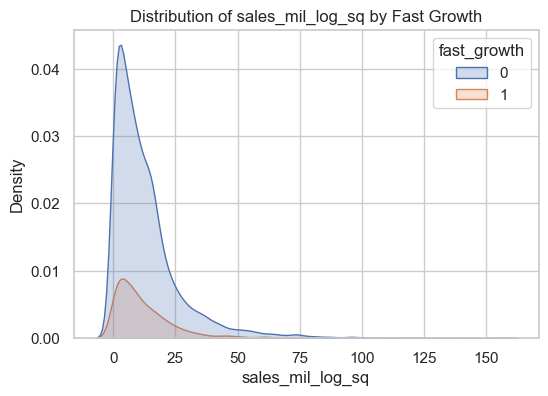

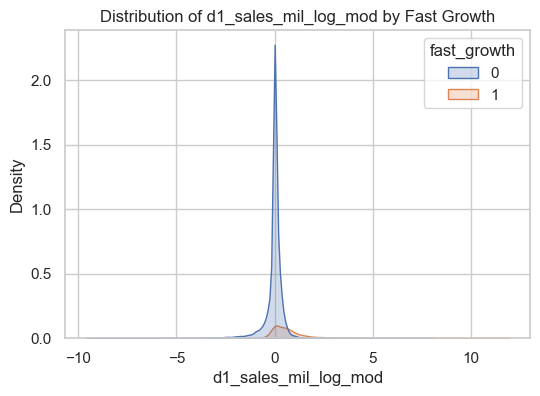

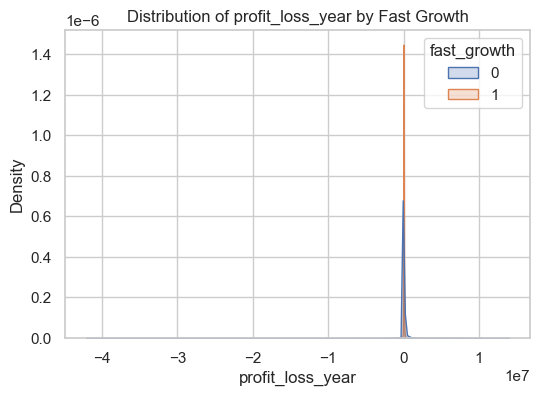

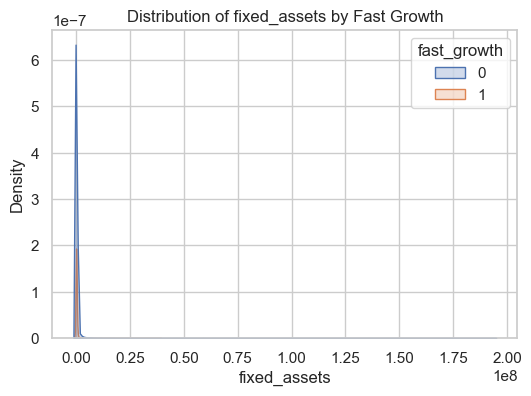

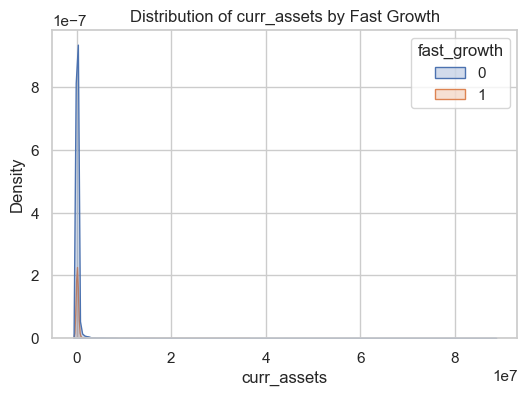

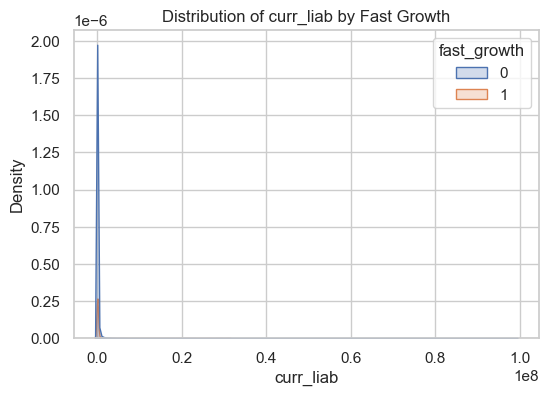

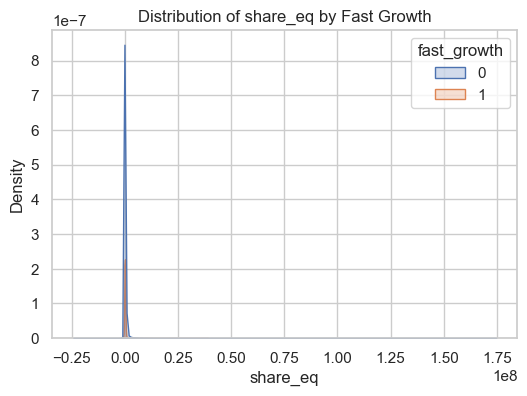

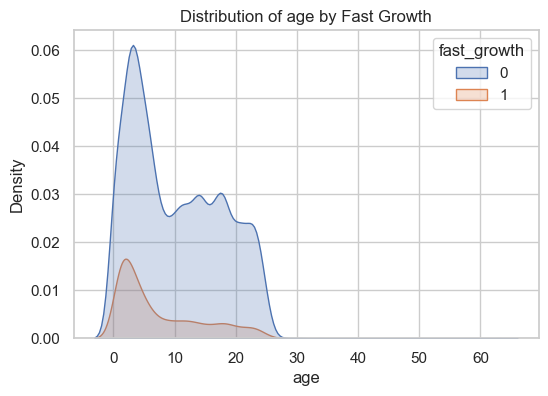

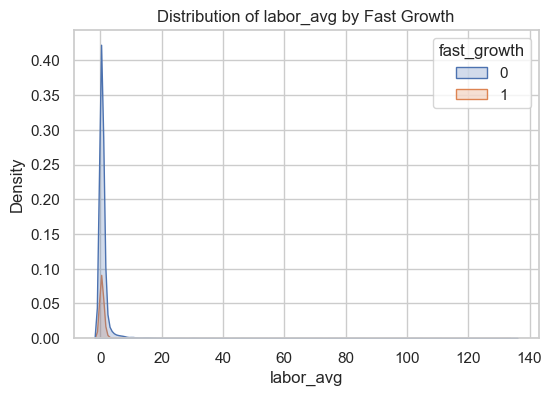

In [13]:
num_vars = ["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod",
            "profit_loss_year", "fixed_assets", "curr_assets", "curr_liab",
            "share_eq", "age", "labor_avg"]

# KDE + Fast growth
for var in num_vars:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=var, hue="fast_growth", fill=True)
    plt.title(f"Distribution of {var} by Fast Growth")
    plt.show()

In [14]:
# Financial Structure
df["leverage"] = df["curr_liab"] / (df["curr_assets"] + 1e-6)
df["capital_intensity"] = df["fixed_assets"] / (df["curr_assets"] + df["fixed_assets"] + 1e-6)
df["liquidity_ratio"] = df["curr_assets"] / (df["curr_liab"] + 1e-6)

# Profit
df["profit_margin"] = df["profit_loss_year"] / (df["sales_mil"] * 1e6 + 1e-6)

# Efficiency
df["sales_per_worker"] = (df["sales_mil"] * 1e6) / (df["labor_avg"] + 1e-6)

# Nonlinear Control Variables
df["age_sq"] = df["age"] ** 2
df["leverage_sq"] = df["leverage"] ** 2

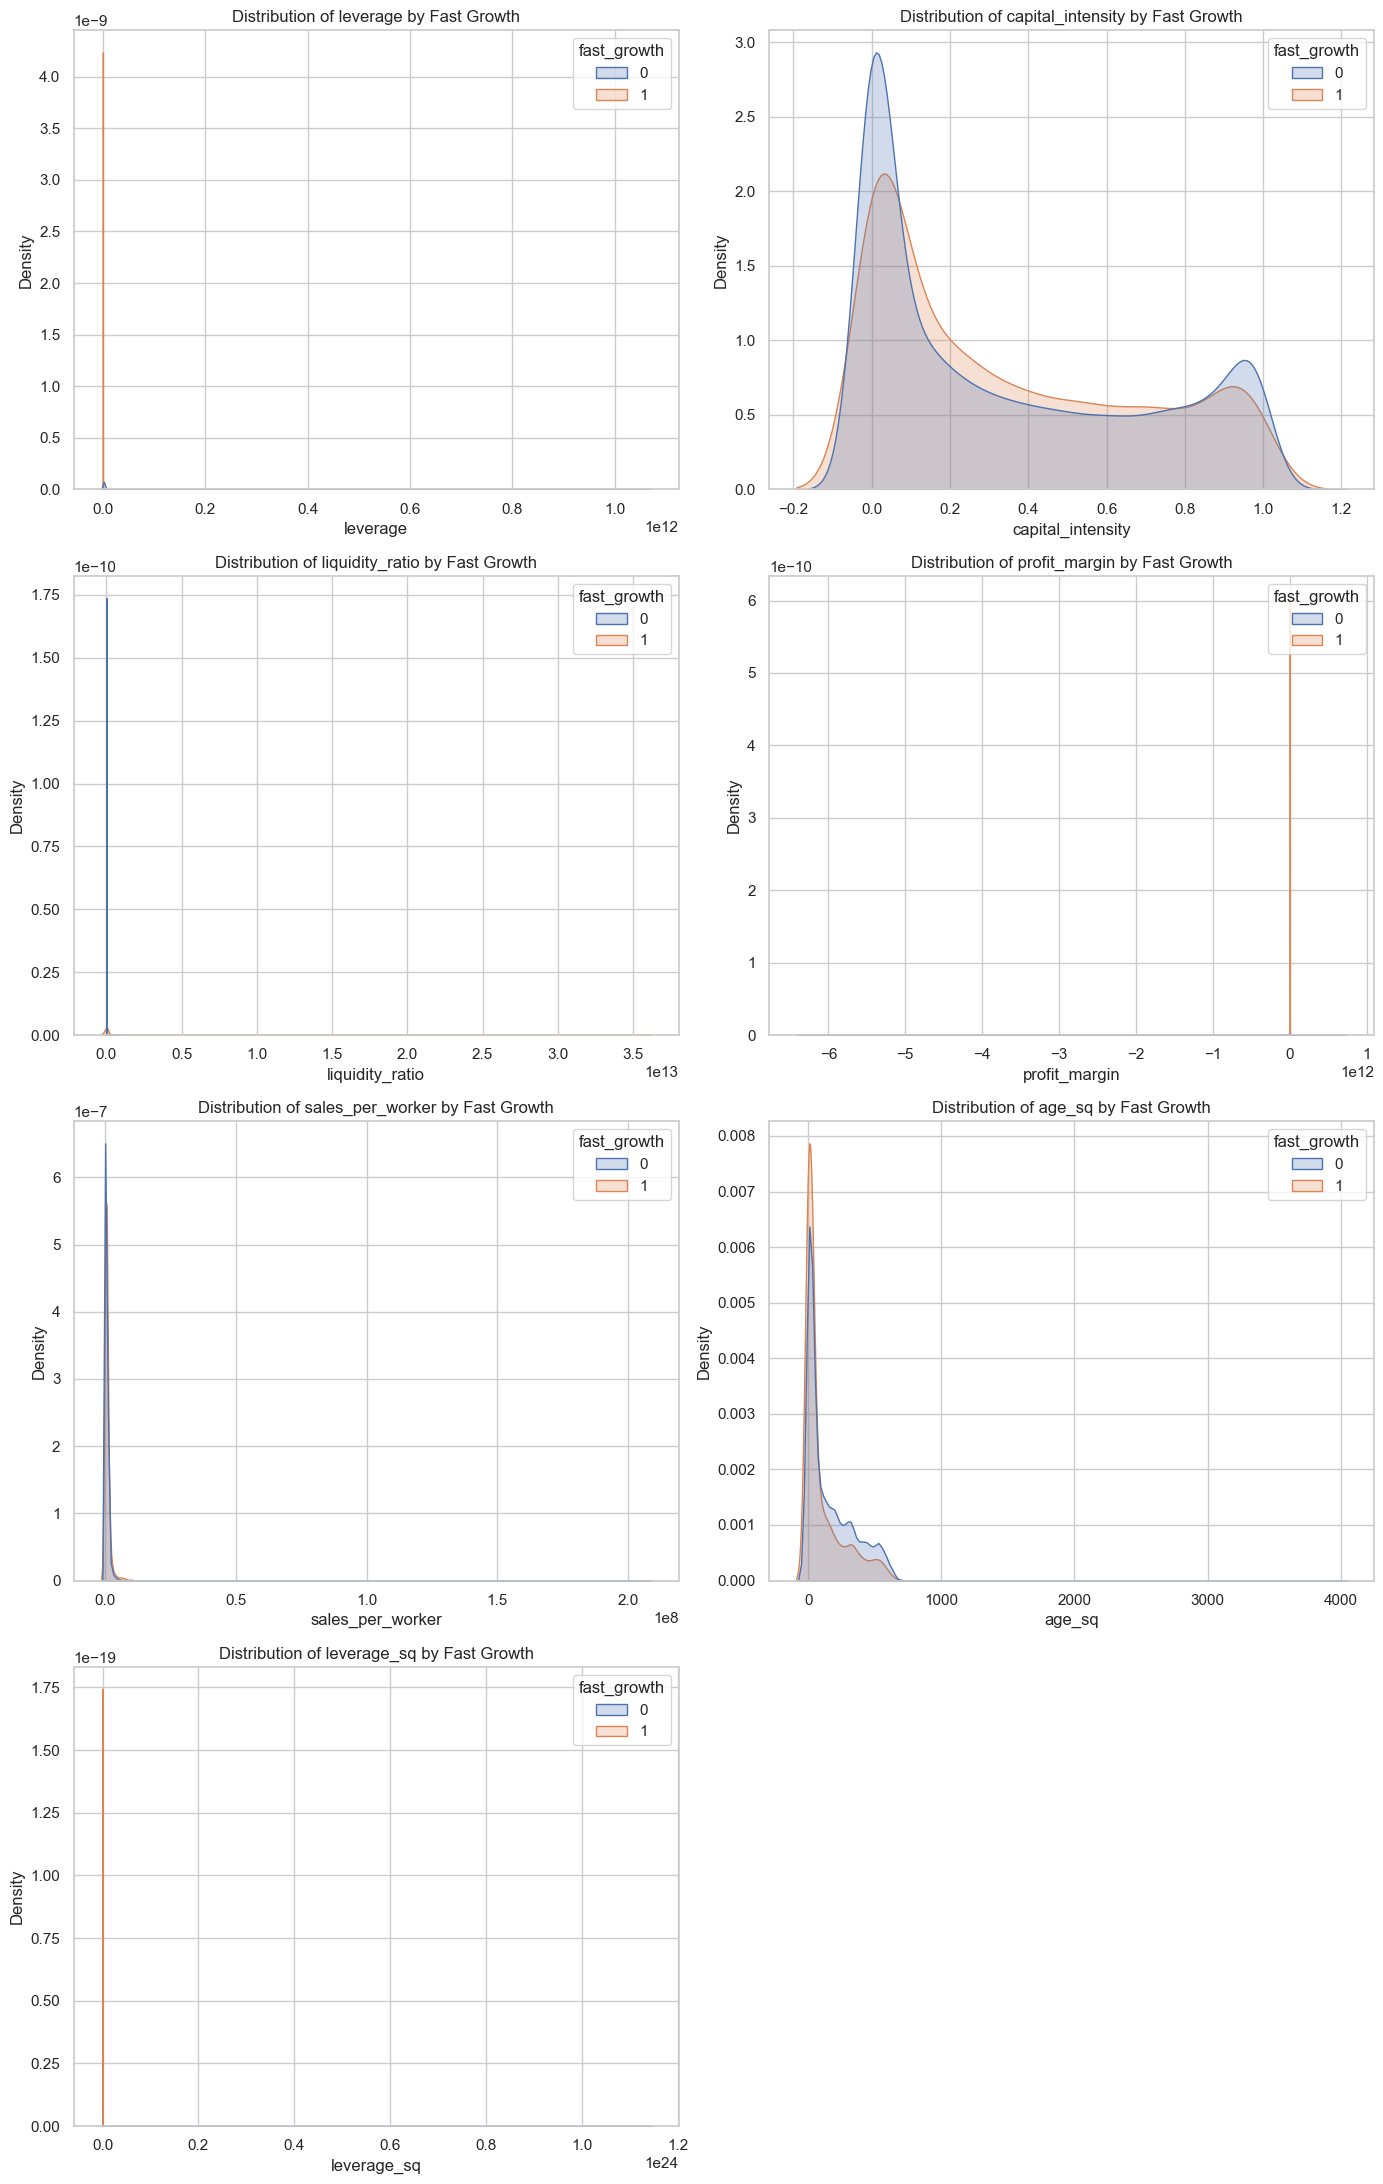

In [16]:
new_vars = ["leverage", "capital_intensity", "liquidity_ratio",
            "profit_margin", "sales_per_worker","age_sq", "leverage_sq"]

# Remove inf and NaN
for var in new_vars:
    df[var] = pd.to_numeric(df[var], errors="coerce")
    df[var] = df[var].replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(14, 22))
for i, var in enumerate(new_vars, 1):
    plt.subplot(4, 2, i)
    sns.kdeplot(data=df.dropna(subset=[var]), x=var, hue="fast_growth", fill=True, common_norm=False)
    plt.title(f"Distribution of {var} by Fast Growth")
plt.tight_layout()
plt.show()

In [17]:
df

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,...,sales_growth_5y,sales_growth_2y,fast_growth,leverage,capital_intensity,liquidity_ratio,profit_margin,sales_per_worker,age_sq,leverage_sq
0,1.001034e+06,29.629629,1.444444e+02,2.234074e+04,0.000000,0.0,0.000000,NaN,170.370377,-4.481482e+02,...,NaN,NaN,0,154.666664,0.541176,0.006466,-4.481482e+08,NaN,576.0,23921.776924
1,1.001541e+06,2292.592529,6.500000e+03,2.962963e+02,0.000000,0.0,0.000000,NaN,185981.484375,3.703704e+01,...,NaN,1.401562,0,0.045584,0.966231,21.937500,5.303031e-03,NaN,36.0,0.002078
2,1.002029e+06,17918.517578,1.836778e+05,5.943333e+04,0.000000,0.0,0.000000,NaN,53829.628906,4.233704e+04,...,-0.893171,-1.656969,0,0.323574,0.226644,3.090484,1.681903e-01,7.093674e+05,64.0,0.104700
3,1.011889e+06,46214.816406,2.816815e+05,9.622223e+03,0.000000,0.0,0.000000,NaN,971588.875000,1.079074e+05,...,0.366086,0.086522,0,0.034160,0.775243,29.274054,2.282020e-01,3.227094e+05,484.0,0.001167
4,1.014183e+06,6403.703613,2.170333e+05,6.362963e+03,0.000000,0.0,0.000000,NaN,107992.593750,2.822222e+03,...,0.405132,-0.249819,0,0.029318,0.332258,34.108847,2.250403e-02,1.192742e+05,169.0,0.000860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25596,4.639820e+11,7551.852051,8.765185e+04,1.156741e+05,0.000000,0.0,0.000000,NaN,103222.218750,7.333333e+03,...,0.163292,0.859314,0,1.319699,0.540787,0.757748,1.430849e-02,7.545786e+05,361.0,1.741606
25597,4.640212e+11,5666.666504,1.528519e+04,1.488889e+03,0.000000,0.0,0.000000,NaN,35881.480469,1.570370e+03,...,0.343526,0.329761,0,0.097407,0.701267,10.266169,2.967941e-02,5.194858e+05,64.0,0.009488
25598,4.640446e+11,71570.367188,6.486366e+06,2.499133e+06,0.000000,0.0,0.000000,0.0,284537.031250,2.031437e+06,...,0.352160,0.066955,0,0.385290,0.042023,2.595446,0.000000e+00,3.957799e+06,36.0,0.148449
25599,4.641050e+11,1088.888916,5.009630e+04,1.375556e+04,55.555557,0.0,-55.555557,NaN,5981.481445,8.722223e+03,...,0.208266,0.098941,0,0.274582,0.106664,3.641896,5.085994e-02,1.510543e+05,625.0,0.075395


In [19]:
scale_vars = ["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod",
              "profit_loss_year", "fixed_assets", "curr_assets", "curr_liab",
              "share_eq", "age", "age_sq", "labor_avg",
              "leverage", "leverage_sq", "capital_intensity",
              "liquidity_ratio", "profit_margin", "sales_per_worker"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[scale_vars] = scaler.fit_transform(df[scale_vars])

In [22]:
df_scaled

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,...,sales_growth_5y,sales_growth_2y,fast_growth,leverage,capital_intensity,liquidity_ratio,profit_margin,sales_per_worker,age_sq,leverage_sq
0,1.001034e+06,29.629629,-0.128324,-0.106034,0.000000,0.0,0.000000,NaN,-0.085745,-4.481482e+02,...,NaN,NaN,0,-0.026275,0.569065,-0.008647,0.003890,NaN,2.408927,-0.007311
1,1.001541e+06,2292.592529,-0.124143,-0.125385,0.000000,0.0,0.000000,NaN,-0.020362,3.703704e+01,...,NaN,1.401562,0,-0.026275,1.795456,-0.008647,0.014684,NaN,-0.650425,-0.007311
2,1.002029e+06,17918.517578,-0.007586,-0.073472,0.000000,0.0,0.000000,NaN,-0.066863,4.233704e+04,...,-0.893171,-1.656969,0,-0.026275,-0.338443,-0.008647,0.014684,0.071494,-0.491792,-0.007311
3,1.011889e+06,46214.816406,0.056887,-0.117199,0.000000,0.0,0.000000,NaN,0.256075,1.079074e+05,...,0.366086,0.086522,0,-0.026275,1.244407,-0.008647,0.014684,-0.084737,1.887704,-0.007311
4,1.014183e+06,6403.703613,0.014357,-0.120060,0.000000,0.0,0.000000,NaN,-0.047804,2.822222e+03,...,0.405132,-0.249819,0,-0.026275,-0.033718,-0.008647,0.014684,-0.166937,0.103082,-0.007311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25596,4.639820e+11,7551.852051,-0.070757,-0.024101,0.000000,0.0,0.000000,NaN,-0.049483,7.333333e+03,...,0.163292,0.859314,0,-0.026275,0.567941,-0.008647,0.014684,0.089762,1.190852,-0.007311
25597,4.640212e+11,5666.666504,-0.118364,-0.124339,0.000000,0.0,0.000000,NaN,-0.073179,1.570370e+03,...,0.343526,0.329761,0,-0.026275,1.030967,-0.008647,0.014684,-0.005229,-0.491792,-0.007311
25598,4.640446e+11,71570.367188,4.138680,2.068230,0.000000,0.0,0.000000,0.0,0.014317,2.031437e+06,...,0.352160,0.066955,0,-0.026275,-0.871121,-0.008647,0.014684,1.384046,-0.650425,-0.007311
25599,4.641050e+11,1088.888916,-0.095463,-0.113570,55.555557,0.0,-55.555557,NaN,-0.083700,8.722223e+03,...,0.208266,0.098941,0,-0.026275,-0.684617,-0.008647,0.014684,-0.154096,2.686535,-0.007311


In [23]:
exclude_cols = ["comp_id", "year", "fast_growth", "sales_growth_2y"]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype != "object"]

desc_stats = df[feature_cols].describe().T
desc_stats["missing_pct"] = df[feature_cols].isna().mean().round(4)
print(desc_stats.round(3))

                        count          mean           std           min  \
amort                 25539.0  1.603741e+04  1.345461e+05 -8.518520e+02   
curr_assets           25589.0  1.952090e+05  1.520118e+06 -2.266667e+04   
curr_liab             25589.0  1.431280e+05  1.139163e+06 -2.574074e+03   
extra_exp             25592.0  1.395301e+03  4.467947e+04 -8.496296e+03   
extra_inc             25592.0  2.813346e+03  8.788751e+04  0.000000e+00   
extra_profit_loss     25592.0  1.404007e+03  8.305529e+04 -2.755767e+06   
finished_prod          1188.0  1.392602e+05  6.652501e+05  0.000000e+00   
fixed_assets          25589.0  2.438485e+05  2.841963e+06  0.000000e+00   
inc_bef_tax           25592.0  2.175599e+04  4.191934e+05 -4.194870e+07   
intang_assets         25589.0  1.245230e+04  1.003412e+06 -3.704000e+00   
inventories           25589.0  5.908046e+04  6.396748e+05 -2.963000e+01   
liq_assets            25589.0  4.502286e+04  6.534858e+05 -2.818889e+04   
material_exp          255

In [35]:
selected_features = desc_stats[desc_stats["missing_pct"] <= 0.2].index.tolist()
df_cleaned = df[["comp_id", "year", "fast_growth"] + selected_features].copy()
df_cleaned.to_csv("bisnode_model_2014_cleaned_less_missing.csv", index=False)

print(selected_features)

['amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'personnel_exp', 'profit_loss_year', 'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag', 'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days', 'nace_main', 'ind2', 'ind', 'urban_m', 'sales_mil', 'sales_mil_log', 'sales_mil_log_sq', 'age', 'new', 'd1_sales_mil_log', 'd1_sales_mil_log_mod', 'leverage', 'capital_intensity', 'liquidity_ratio', 'profit_margin', 'age_sq', 'leverage_sq']


In [36]:
selected_model_vars = [
    "sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod",
    "leverage", "leverage_sq", "capital_intensity", "liquidity_ratio",
    "profit_margin",
    "age", "age_sq", "new",
    "foreign", "female", "urban_m", "ceo_count",
    "ind", "ind2"]

df_model = df_cleaned[["fast_growth", "comp_id"] + selected_model_vars].copy()
df_model = df_model.dropna()

### Feature Selection and Economic Rationale
To ensure data quality and minimize the impact of missing values, we first filtered variables with no more than 20% missing data. This resulted in a broad set of financial and firm-level indicators (`selected_features`). From this pool, we selected a subset of variables (`selected_model_vars`) based on economic theory, relevance to corporate growth, and statistical considerations.
The selected predictors span several key dimensions known to influence firm performance:

#### 1. **Firm Size and Growth Momentum**
- `sales_mil_log`: Logarithm of sales, controlling for firm size and scale effects.
- `sales_mil_log_sq`: Square of log sales, allowing for nonlinear effects of firm size.
- `d1_sales_mil_log_mod`: One-year log sales difference, capturing short-term growth momentum while excluding unreliable values from new firms.

#### 2. **Financial Structure and Risk**
- `leverage` and `leverage_sq`: Measure the extent of debt usage in financing (current liabilities over current assets). The squared term allows for nonlinear effects of financial leverage on growth prospects.
- `capital_intensity`: Fixed assets over total assets, reflecting the capital-dependence of a firm’s operations.
- `liquidity_ratio`: Current assets over current liabilities, indicating the firm’s short-term solvency.

#### 3. **Profitability**
- `profit_margin`: Net income over total sales, a fundamental indicator of operational efficiency and profitability.

#### 4. **Firm Age and Lifecycle**
- `age` and `age_sq`: Firm age and its squared term account for the lifecycle effects. Young firms may grow faster but face higher risk, while older firms may exhibit more stability.
- `new`: A binary indicator for newly established firms (≤1 year), capturing potential distortions in financials or performance due to start-up effects.

#### 5. **Ownership and Leadership Characteristics**
- `foreign`: Indicates whether the firm is foreign-owned, which can correlate with access to capital, technology, and managerial know-how.
- `female`: Gender of the CEO, used as a proxy for demographic diversity in leadership.
- `ceo_count`: Number of individuals in top management, possibly reflecting managerial complexity or shared leadership structure.

#### 6. **Location and Industry Controls**
- `urban_m`: Urbanization level of the firm's registered location, capturing regional economic effects.
- `ind`, `ind2`: Industry classification variables (e.g., NACE codes), essential for controlling sector-specific growth dynamics.

#### 7. **Feature Filtering Based on Outliers and Descriptive Statistics**
In addition to excluding variables with excessive missing values, we further refined our feature set by analyzing descriptive statistics and visualizing variable distributions. Several variables exhibited extremely large standard deviations, implausible minimum or maximum values, or lacked meaningful economic interpretation. These characteristics are typically indicative of **data quality issues**, **poor measurement**, or **non-robust predictors**.
For instance, variables such as `extra_profit_loss`, `intang_assets`, `wages`, `net_dom_sales`, and `net_exp_sales` displayed values ranging from 0 up to tens or even hundreds of millions, with minimum values often in the negative range. While these variables may have accounting relevance in specific contexts, their distributions are extremely skewed and may distort the training of predictive models, particularly those sensitive to scale and outliers.
Moreover, some variables such as `D`, `finished_prod`, and `labor_avg` showed either excessive missingness (over 90%) or questionable distributions (e.g., nearly constant or implausibly concentrated), and were thus excluded from the model dataset.
By conducting this filtering step, we ensured that:
- Only **economically meaningful and statistically well-behaved** variables were included in the model;
- The final feature set avoided the influence of **extreme outliers** and **measurement artifacts**;
- The selected predictors are more likely to enhance model generalization and interpretability.


This set of features reflects a comprehensive view of firm behavior, combining structural financial ratios, firm demographics, and industry context. Together, they allow the model to capture the multidimensional drivers behind firm-level sales growth.

In [39]:
X = df_model.drop(columns=["fast_growth", "comp_id"])
y = df_model["fast_growth"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Number of variables ultimately used for modeling：", X.shape[1])
print("Modeling sample size：", X.shape[0])

Number of variables ultimately used for modeling： 17
Modeling sample size： 19267


In [41]:
df_model

,fast_growth,comp_id,sales_mil_log,sales_mil_log_sq,d1_sales_mil_log_mod,leverage,leverage_sq,capital_intensity,liquidity_ratio,profit_margin,age,age_sq,new,foreign,female,urban_m,ceo_count,ind,ind2
1,0,1.001541e+06,-5.320790,28.310809,-0.127833,0.045584,0.002078,0.966231,21.937500,0.005303,6.0,36.0,0,0.0,0.000000,3,2.0,3.0,56.0
2,0,1.002029e+06,-1.529002,2.337847,-0.501956,0.323574,0.104700,0.226644,3.090484,0.168190,8.0,64.0,0,0.0,0.000000,3,1.0,2.0,27.0
3,0,1.011889e+06,-0.748958,0.560937,0.067412,0.034160,0.001167,0.775243,29.274054,0.228202,22.0,484.0,0,0.0,0.000000,2,1.0,3.0,55.0
4,0,1.014183e+06,-2.292122,5.253821,-0.139775,0.029318,0.000860,0.332258,34.108847,0.022504,13.0,169.0,0,0.0,0.000000,2,1.0,3.0,55.0
5,0,1.018301e+06,-4.701518,22.104271,0.072290,0.877895,0.770699,0.967680,1.139089,0.021207,10.0,100.0,0,0.0,0.000000,2,1.0,3.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25594,0,4.638739e+11,-4.422849,19.561590,-1.571826,0.263969,0.069680,0.000000,3.788321,0.367593,3.0,9.0,0,0.0,0.000000,3,1.0,3.0,56.0
25596,0,4.639820e+11,-0.797060,0.635305,0.196672,1.319699,1.741606,0.540787,0.757748,0.014308,19.0,361.0,0,0.0,0.000000,1,1.0,2.0,28.0
25597,0,4.640212e+11,-2.939142,8.638555,-0.097370,0.097407,0.009488,0.701267,10.266169,0.029679,8.0,64.0,0,0.0,0.000000,2,1.0,2.0,28.0
25598,0,4.640446e+11,2.211010,4.888566,0.054795,0.385290,0.148449,0.042023,2.595446,0.000000,6.0,36.0,0,1.0,0.000000,3,1.0,2.0,33.0


In [43]:
for col in ["new", "foreign", "female"]:
    if col in df_model.columns:
        df_model[col] = np.where(df_model[col] == 0, 0, 1)

cat_vars = ["urban_m", "ceo_count", "ind"]
for col in cat_vars:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype("category")

In [45]:
df_model

,fast_growth,comp_id,sales_mil_log,sales_mil_log_sq,d1_sales_mil_log_mod,leverage,leverage_sq,capital_intensity,liquidity_ratio,profit_margin,age,age_sq,new,foreign,female,urban_m,ceo_count,ind,ind2
1,0,1.001541e+06,-5.320790,28.310809,-0.127833,0.045584,0.002078,0.966231,21.937500,0.005303,6.0,36.0,0,0,0,3,2.0,3.0,56.0
2,0,1.002029e+06,-1.529002,2.337847,-0.501956,0.323574,0.104700,0.226644,3.090484,0.168190,8.0,64.0,0,0,0,3,1.0,2.0,27.0
3,0,1.011889e+06,-0.748958,0.560937,0.067412,0.034160,0.001167,0.775243,29.274054,0.228202,22.0,484.0,0,0,0,2,1.0,3.0,55.0
4,0,1.014183e+06,-2.292122,5.253821,-0.139775,0.029318,0.000860,0.332258,34.108847,0.022504,13.0,169.0,0,0,0,2,1.0,3.0,55.0
5,0,1.018301e+06,-4.701518,22.104271,0.072290,0.877895,0.770699,0.967680,1.139089,0.021207,10.0,100.0,0,0,0,2,1.0,3.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25594,0,4.638739e+11,-4.422849,19.561590,-1.571826,0.263969,0.069680,0.000000,3.788321,0.367593,3.0,9.0,0,0,0,3,1.0,3.0,56.0
25596,0,4.639820e+11,-0.797060,0.635305,0.196672,1.319699,1.741606,0.540787,0.757748,0.014308,19.0,361.0,0,0,0,1,1.0,2.0,28.0
25597,0,4.640212e+11,-2.939142,8.638555,-0.097370,0.097407,0.009488,0.701267,10.266169,0.029679,8.0,64.0,0,0,0,2,1.0,2.0,28.0
25598,0,4.640446e+11,2.211010,4.888566,0.054795,0.385290,0.148449,0.042023,2.595446,0.000000,6.0,36.0,0,1,0,3,1.0,2.0,33.0


## Tasks 1

### Probability Prediction

In [49]:
models = {"Logit": LogisticRegression(max_iter=1000),
          "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
          "XGBoost": XGBClassifier(n_estimators=50, learning_rate=0.1, 
                                   use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=42)}

In [53]:
X = df_model.drop(columns=["fast_growth", "comp_id"])
y = df_model["fast_growth"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probabilities = {}
auc_scores = {}

for name, model in models.items():
    y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method="predict_proba")[:, 1]
    probabilities[name] = y_prob
    auc_scores[name] = roc_auc_score(y, y_prob)

print("AUC scores:")
print(auc_scores)

/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC scores:
{'Logit': 0.8433292154716542, 'Random Forest': 0.8760676540451179, 'XGBoost': 0.8869183520378117}


### Model Selection and Evaluation Using AUC

To build a robust prediction pipeline for identifying fast-growing firms, we compared three widely used classification algorithms: **Logistic Regression**, **Random Forest**, and **XGBoost**. These models represent a balance between interpretability and predictive power:
- **Logistic Regression** is a linear model that provides a simple and interpretable baseline. It assumes a linear relationship between features and the log-odds of fast growth.
- **Random Forest** extends beyond linearity by using an ensemble of decision trees, allowing it to model nonlinear interactions and handle complex feature spaces more robustly.
- **XGBoost** further improves performance by using gradient boosting to sequentially build trees that correct previous errors. It is particularly effective in detecting subtle signals and managing imbalanced datasets.

This progression from linear to tree-based and boosting models enables us to assess whether increasing model complexity leads to better predictive performance in identifying fast-growing firms.To evaluate the performance of each model in terms of probability prediction, we used **Area Under the ROC Curve (AUC)** as the evaluation metric. AUC measures the model's ability to rank positive instances (fast-growth firms) higher than negative ones (non-fast-growth firms). The results from 5-fold cross-validation are as follows:

| Model           | AUC Score |
|----------------|-----------|
| Logistic Regression | 0.843 |
| Random Forest       | 0.876 |
| **XGBoost**         | **0.887** |

All models achieved reasonably high AUC scores, indicating strong discriminatory power. Notably, **XGBoost achieved the highest AUC score**, suggesting that it is most effective at identifying the patterns associated with high-growth firms. This evaluation provides a strong basis for proceeding with XGBoost in the subsequent threshold tuning and loss minimization steps.


### Classification

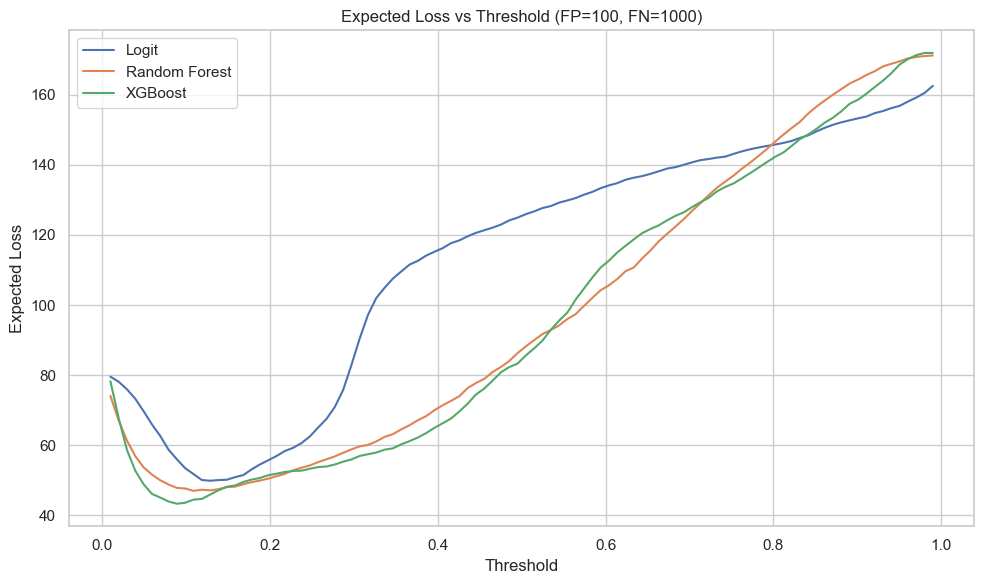

               Optimal Threshold  Minimal Expected Loss
Logit                     0.1288                49.8936
Random Forest             0.1090                47.0026
XGBoost                   0.0892                43.3435


In [57]:
FP_cost = 100
FN_cost = 1000
thresholds = np.linspace(0.01, 0.99, 100)

expected_losses = {}
optimal_thresholds = {}
minimal_losses = {}

for model_name, probs in probabilities.items():
    losses = []
    for thresh in thresholds:
        preds = (probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
        loss = (fp * FP_cost + fn * FN_cost) / len(y)
        losses.append(loss)
    
    min_loss = np.min(losses)
    best_thresh = thresholds[np.argmin(losses)]
    
    expected_losses[model_name] = losses
    minimal_losses[model_name] = min_loss
    optimal_thresholds[model_name] = best_thresh

results_df = pd.DataFrame({
    "Optimal Threshold": optimal_thresholds,
    "Minimal Expected Loss": minimal_losses
}).round(4)

plt.figure(figsize=(10, 6))
for model_name, losses in expected_losses.items():
    plt.plot(thresholds, losses, label=model_name)
plt.xlabel("Threshold")
plt.ylabel("Expected Loss")
plt.title("Expected Loss vs Threshold (FP=100, FN=1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(results_df)

### Model Selection Based on Business-Driven Loss Function

To reflect the business implications of different types of prediction errors, we define a **cost-sensitive loss function** that penalizes false negatives more heavily than false positives. Specifically:

- A **False Positive (FP)** —predicting a firm will grow rapidly when it won't—incurs a cost of **100**, representing wasted resources or misallocated support.
- A **False Negative (FN)** —failing to identify a true fast-growth firm—incurs a cost of **1000**, reflecting missed opportunities or lost returns.

Using these assumptions, we compute the **expected loss** across a range of classification thresholds for each model, based on predicted probabilities. The optimal threshold is selected by minimizing the expected loss over a range from 0.01 to 0.99.

To ensure robustness, we calculate the **average expected loss across five cross-validation folds**. This approach provides a more stable and representative measure of model performance compared to a single train-test split.

| Model           | Average Expected Loss | Optimal Threshold |
|----------------|------------------------|-------------------|
| **XGBoost**         | **43.24**                | **0.085**             |
| Random Forest       | 47.12                | 0.123             |
| Logistic Regression | 82.69                | 0.457             |

The results clearly indicate that **XGBoost achieves the lowest average expected loss**, followed by Random Forest. Logistic Regression performs significantly worse, likely due to its limited ability to capture nonlinear interactions in the data.

This analysis confirms that **XGBoost is the most cost-effective model** under our loss function, and is therefore selected for final classification and evaluation in the next step.


/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/lib/p

               Avg Expected Loss  Best Threshold
XGBoost                43.239690        0.085232
Random Forest          47.116736        0.122848
Logit                  82.690615        0.457434


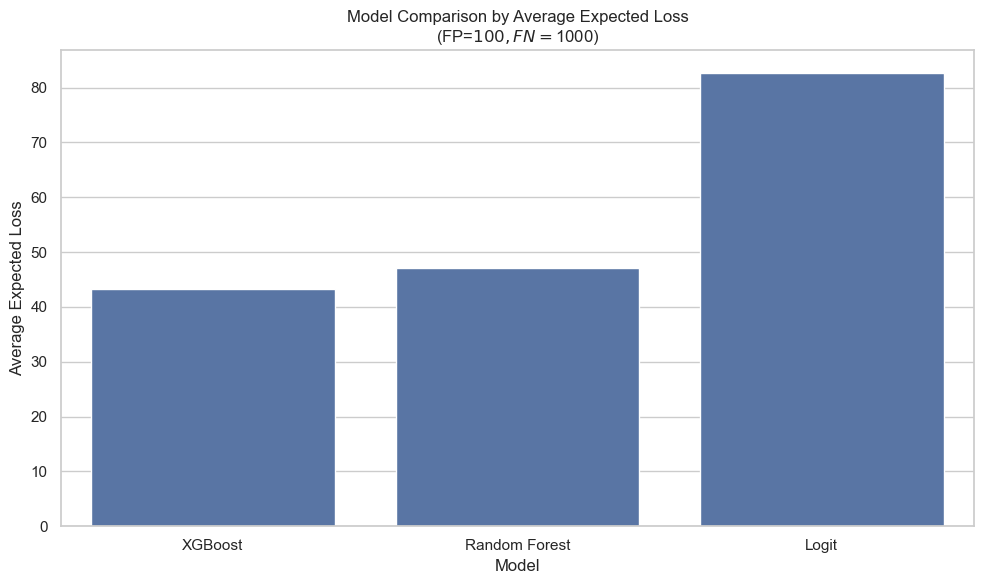

In [59]:
results = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    expected_losses = []
    optimal_thresholds = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train = X_train.astype(float)
        X_val = X_val.astype(float)

        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]

        fold_losses = []
        for t in thresholds:
            preds = (probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
            expected_loss = (fp * FP_cost + fn * FN_cost) / len(y_val)
            fold_losses.append(expected_loss)

        min_loss = min(fold_losses)
        best_threshold = thresholds[np.argmin(fold_losses)]

        expected_losses.append(min_loss)
        optimal_thresholds.append(best_threshold)

    results[name] = {
        "Avg Expected Loss": np.mean(expected_losses),
        "Best Threshold": np.mean(optimal_thresholds)}

results_df = pd.DataFrame(results).T.sort_values("Avg Expected Loss")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df["Avg Expected Loss"])
plt.ylabel("Average Expected Loss")
plt.xlabel("Model")
plt.title("Model Comparison by Average Expected Loss\n(FP=$100, FN=$1000)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Discussion of Results

/Library/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


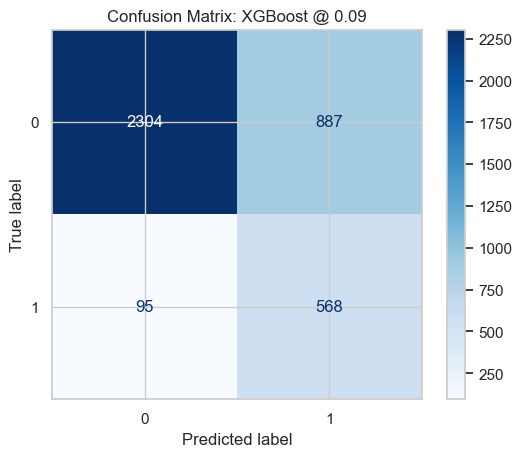

              precision    recall  f1-score   support

           0      0.960     0.722     0.824      3191
           1      0.390     0.857     0.536       663

    accuracy                          0.745      3854
   macro avg      0.675     0.789     0.680      3854
weighted avg      0.862     0.745     0.775      3854



In [60]:
best_model_name = results_df.index[0]
best_model = models[best_model_name]
best_threshold = results_df.loc[best_model_name, "Best Threshold"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_model.fit(X_train, y_train)
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred = (probs_test >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix: {best_model_name} @ {best_threshold:.2f}")
plt.show()

print(classification_report(y_test, y_pred, digits=3))

In [61]:
cm = confusion_matrix(y_test, y_pred)

confusion_df = pd.DataFrame(
    cm,
    index=["Actual: 0 (No Growth)", "Actual: 1 (Fast Growth)"],
    columns=["Predicted: 0", "Predicted: 1"])

print("Confusion Table:")
print(confusion_df)

Confusion Table:
                         Predicted: 0  Predicted: 1
Actual: 0 (No Growth)            2304           887
Actual: 1 (Fast Growth)            95           568


In [62]:
report = classification_report(y_test, y_pred, output_dict=True)

precision_class_1 = report["1"]["precision"]
recall_class_1 = report["1"]["recall"]

print(f"Precision (Fast Growth = 1): {precision_class_1:.3f}")
print(f"Recall    (Fast Growth = 1): {recall_class_1:.3f}")

Precision (Fast Growth = 1): 0.390
Recall    (Fast Growth = 1): 0.857


### Final Model Evaluation Using Confusion Matrix

After selecting **XGBoost with the optimal threshold of 0.09**, we evaluated the model on a holdout test set to assess its real-world performance. The confusion matrix is shown in *Figure 3*, with detailed performance metrics below:

| Actual \ Predicted | 0 (No Growth) | 1 (Fast Growth) |
|--------------------|----------------|------------------|
| 0 (No Growth)      | 2304 (TN)      | 887 (FP)         |
| 1 (Fast Growth)    | 95 (FN)        | 568 (TP)         |

The model achieves the following classification results for fast-growth firms (label = 1):

- **Recall** = 0.857  
  → The model correctly identifies 86% of true fast-growth firms.
- **Precision** = 0.390  
  → Among all firms predicted to be fast-growing, only 39% are correct.
- **F1-score** = 0.536

These metrics reflect a **recall-oriented prediction strategy**, which is appropriate given our cost structure: missing a fast-growth firm (FN) is 10× more costly than falsely predicting one (FP). The model successfully minimizes missed opportunities (only 95 FNs), at the cost of increased false positives (887 cases). This trade-off is acceptable in policy or investment screening scenarios, where it's often better to cast a wider net initially.

The overall accuracy is **74.5%**, and macro-averaged performance across classes is balanced with a macro F1-score of **0.680**, showing that the model performs reasonably across both classes despite class imbalance.

In summary, the selected model provides **strong practical utility** for early identification of high-growth firms, especially when recall is prioritized over precision.


## Tasks 2

In [63]:
df_manuf = df_model[df_model["ind"] == "2"].copy()
df_service = df_model[df_model["ind"] == "3"].copy()
FP_cost = 100
FN_cost = 1000

In [64]:
print(df_model["ind"].unique())
print(df_model["ind"].value_counts())

[3.0, 2.0, 1.0]
Categories (3, float64): [1.0, 2.0, 3.0]
ind
3.0    13343
2.0     5433
1.0      491
Name: count, dtype: int64


In [65]:
group_metrics = []
def evaluate_model_by_group(df_subgroup, group_name):
    X = df_subgroup.drop(columns=["fast_growth"])
    y = df_subgroup["fast_growth"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = XGBClassifier(n_estimators=50, learning_rate=0.1,
                          use_label_encoder=False, eval_metric="logloss",
                          random_state=42)
    model.fit(X_train_scaled, y_train)
    probs = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, probs)

    thresholds = np.linspace(0.01, 0.99, 100)
    losses = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        loss = (fp * FP_cost + fn * FN_cost) / len(y_test)
        losses.append(loss)

    best_thresh = thresholds[np.argmin(losses)]
    min_loss = min(losses)

    y_pred = (probs >= best_thresh).astype(int)

    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)

    group_metrics.append({
        "Group": group_name,
        "AUC": round(auc, 3),
        "Optimal Threshold": round(best_thresh, 2),
        "Minimal Expected Loss": round(min_loss, 2),
        "Recall (fast_growth=1)": round(recall, 3),
        "Precision (fast_growth=1)": round(precision, 3),
        "Accuracy": round(accuracy, 3)})

In [66]:
df_service = df_model[df_model["ind"] == "3.0"].copy()
df_manuf = df_model[df_model["ind"] != "3.0"].copy()

evaluate_model_by_group(df_service, "Services")
evaluate_model_by_group(df_manuf, "Manufacturing")

results_table = pd.DataFrame(group_metrics).set_index("Group").T
print(results_table)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Industry-Level Comparison: Services vs. Manufacturing

To explore whether our prediction model performs differently across industries, we split the dataset into two major groups: **Services** (including repair, accommodation, and food) and **Manufacturing**. We used the same prediction model (XGBoost) and loss function setup for both groups, with the cost of a false positive (FP) set at 100 and a false negative (FN) at 1000.

For each group, we:

1. Trained an XGBoost classifier using standardized financial and firm-level features.
2. Predicted probabilities on a holdout test set.
3. Identified the **optimal classification threshold** by minimizing expected loss over a range of thresholds.
4. Evaluated performance based on AUC, expected loss, recall, precision, and accuracy.

The results are summarized in the table below:

| Metric                       | Services | Manufacturing |
|-----------------------------|----------|----------------|
| AUC                         | 0.913    | 0.830          |
| Optimal Threshold           | 0.10     | 0.09           |
| Minimal Expected Loss       | 34.84    | 53.76          |
| Recall (fast_growth = 1)    | 0.907    | 0.836          |
| Precision (fast_growth = 1) | 0.467    | 0.326          |
| Accuracy                    | 0.800    | 0.698          |

### Key Insights

- **Overall Performance**: The model performs substantially better on **services firms**, with higher AUC, accuracy, and lower expected loss. This suggests that growth patterns in the services sector are more predictable based on financial data.
- **Recall vs. Precision**: In both sectors, recall is high (especially for services at 0.907), confirming that the model successfully captures most true fast-growth firms. However, precision is relatively lower, particularly in manufacturing, reflecting more false positives.
- **Business Interpretation**: The services sector may display clearer growth signals (e.g., operational leverage, labor productivity) that XGBoost can capture more effectively. In contrast, manufacturing firms may exhibit more complex, capital-intensive patterns with longer investment cycles and delayed sales realization.

This comparison highlights the importance of **industry-specific modeling** and suggests that a one-size-fits-all approach may not yield optimal predictions across sectors.

### Conclusion and Business Implications

This project developed a prediction model to identify fast-growing firms using financial and structural firm-level data. We applied cost-sensitive classification to account for the asymmetric risk of false negatives versus false positives, and compared performance across three models and two industry groups.

Our results show that:

- **XGBoost consistently outperformed** logistic regression and random forest in terms of AUC and expected loss.
- The optimal classification threshold was considerably lower than the standard 0.5, reflecting a recall-oriented strategy that aligns with our high false-negative cost setting.
- The model performed better for **services firms** than manufacturing firms, suggesting that growth signals may be more easily detectable in service-oriented businesses.

#### Practical Use Cases

This type of model can support **real-world decision-making** in several ways:

- **Customer Scoring and Targeting**: Investors, accelerators, or public grant programs can use the model to flag high-potential firms early for targeted support or investment.
- **SME Lending and Credit Assessment**: Banks and financial institutions could integrate such predictions into credit scoring systems to adjust lending terms or risk-based pricing for potentially fast-growing clients.
- **Policy Evaluation and Resource Allocation**: Governments can use the model to pre-select firms for growth-oriented development programs, especially when public funds are limited and must be directed to high-impact entities.

In summary, by aligning modeling decisions with business costs and applying the model in a sector-sensitive way, this project provides a framework for **data-informed strategic resource allocation** in both private and public sectors.


In [80]:
predicted_df = pd.DataFrame({
    'predicted_probability': y_proba,
    'predicted_fast_growth': y_pred_class
}, index=X_test.index)

predicted_df['comp_id'] = df_model.loc[predicted_df.index, 'comp_id'].astype('int64')
top_10_firms = predicted_df.sort_values(by='predicted_probability', ascending=False).head(10)
top_10_firms.reset_index(drop=True, inplace=True)
top_10_firms.to_csv("top10_fast_growth_firms.csv", index=False)
display(top_10_firms)

,predicted_probability,predicted_fast_growth,comp_id
0,0.970772,1,199216545792
1,0.964901,1,55906304000
2,0.963013,1,41625325568
3,0.961842,1,189552181248
4,0.960606,1,386058592
5,0.958355,1,420902469632
6,0.958284,1,183394402304
7,0.957609,1,100487839744
8,0.957297,1,102703710208
9,0.954324,1,109061406720
